In [1]:
# Managing warnings
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import math

# Plot the Figures Inline
%matplotlib inline

# Load Dataset

In [2]:
## display option
pd.set_option('display.max_columns', None)

In [3]:
## missing values
missing_values = ['n/a', 'na', '-', '*']

In [4]:
## encoding
#find the file encoding type (warning: it takes so long time, so just put the exact number)
import chardet

with open('./data/takehome_users.csv', 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.7298523315812625, 'language': ''}


In [5]:
users = pd.read_csv('./data/takehome_users.csv', 
                    parse_dates=['creation_time'], 
                    encoding=result['encoding'], na_values=missing_values)
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


In [7]:
user_engagement = pd.read_csv('./data/takehome_user_engagement.csv', parse_dates=['time_stamp'])
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [8]:
user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [9]:
## null check
users.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [10]:
user_engagement.isnull().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

## Handling Missing Values

There are missing values for `last_session_creation_time` and `invited_by_user_id`. There are no missing values in the user_engagement dataframe. We first fill the missing values in `invited_by_user_id` with zero.

In [11]:
users['invited_by_user_id'] = users['invited_by_user_id'].fillna(0)

The `last_session_creation_time` is unix timestamp of last login. We convert it to datetime object.
We fill the missing values of `last_session_creation_time` with the `creation_time`.

In [12]:
#now set that to datetime (don't forget to use unit='s')
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

In [13]:
users['last_session_creation_time'] = users['last_session_creation_time'].fillna(users['creation_time'])

# Data Wrangling

## Labeling

###  Adopted Users (`adopted`)

In [14]:
## create a new column that computes the rolling count over a specific window period
## apply with function definition, map with lambda 

def get_rolling_count(df, freq):
    return df.rolling(freq, on='time_stamp')['visited'].count()

user_engagement['visited_7days'] = user_engagement.groupby('user_id', as_index=False, group_keys=False).apply(get_rolling_count, freq='7D')

user_engagement.head()

,time_stamp,user_id,visited,visited_7days
0,2014-04-22 03:53:30,1,1,1.0
1,2013-11-15 03:45:04,2,1,1.0
2,2013-11-29 03:45:04,2,1,1.0
3,2013-12-09 03:45:04,2,1,1.0
4,2013-12-25 03:45:04,2,1,1.0


In [15]:
print("Total number of engaged users: {}".format(user_engagement.user_id.nunique()))

Total number of engaged users: 8823


In [16]:
#adopted = user_engagement[user_engagement.visited_7days >= 3]
adopted = user_engagement.loc[(user_engagement['visited_7days'] >= 3)]
adopted = adopted.drop_duplicates('user_id', keep = 'first')
print("Number of adopted users: {}".format(len(adopted)))
adopted.head()

Number of adopted users: 1602


,time_stamp,user_id,visited,visited_7days
9,2014-02-09 03:45:04,2,1,3.0
27,2013-02-19 22:08:03,10,1,3.0
312,2014-03-13 11:46:38,20,1,3.0
331,2014-03-23 06:29:09,33,1,3.0
354,2012-12-26 19:05:07,42,1,3.0


In [17]:
# adopted users
adopted_ids = adopted.user_id.tolist()

In [18]:
# new column of adopted users 
# user_id = object_id

# True or False
users['adopted'] = users['object_id'].isin(adopted_ids)

# 1 (True) or 0 (False) : .astype(int)
#users['adopted'] = users['object_id'].isin(adopted_ids).astype(int)
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False


## Derived Features

We derive the features that can be good indicators for identifying adopted users.

- Days between Initial Login and First Creation (`days_creation_firstLogin`)
- Top 3 email domains and others (`email_domain`)
- Length of usage : Time between First Creation and Last Session (`length_usage`)
- Average time of login intervals (`avg_login`)
- Number of user's referrals (`num_referrals`)
- Impact of inviter as influencer (`invited_by_size_inf` (Large/Medium/Small))
- Frequency of organization (`org_size_inf_num`, `org_size_inf_cat` (Extreme/Many/Moderate/Small/Few))

### Days between Initial Login and First Creation (`days_creation_firstLogin`)

In [19]:
# initial login
df_firstLogin = user_engagement.groupby('user_id', as_index=False).agg({'time_stamp' : np.min})
df_firstLogin.columns=['object_id', 'firstLogin_time']
df_firstLogin.head()

,object_id,firstLogin_time
0,1,2014-04-22 03:53:30
1,2,2013-11-15 03:45:04
2,3,2013-03-19 23:14:52
3,4,2013-05-22 08:09:28
4,5,2013-01-22 10:14:20


In [20]:
# merge
users = users.merge(df_firstLogin, how='left', on='object_id')

In [21]:
# convert datetime64[ns] to float
users['days_creation_firstLogin'] = (users['firstLogin_time'] - users['creation_time']).dt.days #datetime64[ns]
# missing values 
users['days_creation_firstLogin'] = users['days_creation_firstLogin'].fillna(0)
users['firstLogin_time'] = users['firstLogin_time'].fillna(users['creation_time'])

### Top 3 email domains and other (`email_domain`)

In [22]:
users['email_domain'] = [x.split('@')[1] for x in users.email] # extract domain

In [23]:
top3_domains = users.email_domain.value_counts().index[:3] # top 3 domains
print("Top 3 domains: {}".format(top3_domains))
users['email_domain'] = [x if x in top3_domains else "other" for x in users.email_domain]

Top 3 domains: Index(['gmail.com', 'yahoo.com', 'jourrapide.com'], dtype='object')


### Length of usage : Time between First Creation and Last Session (`length_usage`)
The length usage denotes the days from the first account creation to the last login time. This feature represents how a user consistenly have has been used the services.

In [24]:
#subtract to find time active
users['length_usage'] = users['last_session_creation_time'] - users['creation_time']

In [25]:
#users['length_usage'] = users['length_usage'].total_seconds() #timedelta64[ns]
#users.info() 

# convert timedelta64[ns] to int
users['length_usage'] = users['length_usage'].dt.components.days

### Average time of login intervals (`avg_login`)

This feature indicates the average time a user remains once they login to the system.
This is calculated as the difference of the current time and the preceding time.

In [26]:
# this applies to every elements and aggregates into mean?
def calculateInterval(x):
    return x - x.shift()

users['avg_login'] = user_engagement.groupby('user_id').time_stamp.apply(calculateInterval).dt.days
#user_engagement.loc[user_engagement['user_id']==2].time_stamp
users['avg_login'] = users['avg_login'].fillna(0)

### Number of user's referrals (`num_referrals`)

This feature shows how many times a user has attracted other users who have created new accounts.

In [27]:
user_invited = pd.DataFrame(users.invited_by_user_id.value_counts()).reset_index()
user_invited.columns=['object_id', 'num_referrals']
users = users.merge(user_invited, how='left', on='object_id')
users['num_referrals'] = users['num_referrals'].fillna(0)

### Impact of inviter as influencer (`invited_by_size_inf` (Large/Medium/Small))

This feature denotes the impact of an inviter as an influencer. 
The inviter is the person who recommend the system to a user.
If a user has been invited by the inviter who has attracted many users (high `num_referrals`), this feature will be marked as "L" (large).

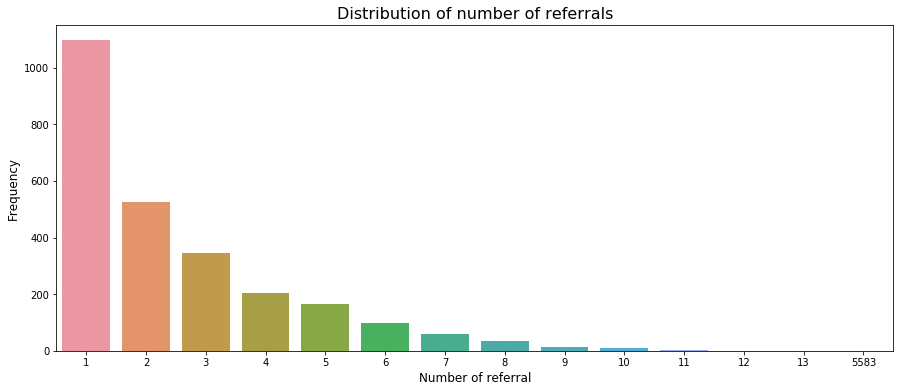

In [28]:
#plot distribution
fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(user_invited.num_referrals, ax=ax)
ax.set_title('Distribution of number of referrals', fontsize=16)
ax.set_xlabel('Number of referral', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

In [29]:
def getReferralSize(x):
    size='M' #default M (2,3,4)
    if x>=5: # 5~13: Large
        size='L'
    elif x<=1: # 1: Small
        size='S'
    return size

user_invited['invited_by_size_inf']=user_invited.num_referrals.apply(getReferralSize)

In [30]:
inviter_size_dict = dict(zip(user_invited.object_id, user_invited.invited_by_size_inf))
inviter_size_dict[0] = np.nan

In [31]:
#inviter_size_dict
# find key and value in dictionary

# for object_id, invited_by_size_inf in inviter_size_dict.items():    
#     if object_id == 316:
#         print(invited_by_size_inf)

In [32]:
users['invited_by_size_inf'] = users.invited_by_user_id.map(inviter_size_dict) 
#use "users.invited_by_user_id" as key and return value of "user_invited.invited_by_size_inf"
users['invited_by_size_inf'] = users['invited_by_size_inf'].fillna("Not_invited")

### Frequency of organization (`org_size_inf_num`, `org_size_inf_cat` (Extreme/Many/Moderate/Small/Few))

In [33]:
org_count = pd.DataFrame(users.org_id.value_counts()).reset_index()
org_count.columns=['org_id', 'num_org']

In [34]:
#users[users.org_id == 396].shape[0] #9
#there are 9 users with 396 organization

Text(0, 0.5, 'Frequency of organization')

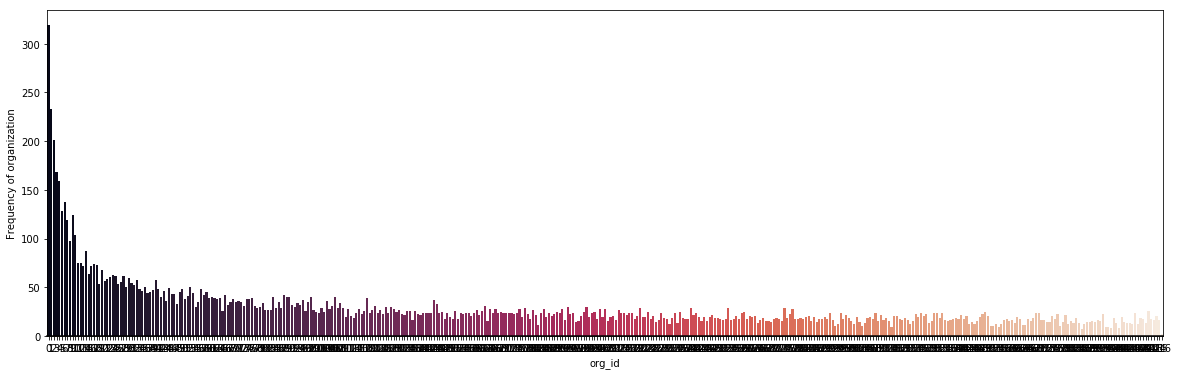

In [35]:
#plot distribution
fig, ax = plt.subplots(figsize=(20, 6))
# sns.countplot(org_count.num_org, ax=ax)
# ax.set_title('Distribution of number of organization', fontsize=16)
# ax.set_xlabel('Number of organization', fontsize=12)
# ax.set_ylabel('Frequency', fontsize=12)
# plt.show()

sns.barplot(x=org_count.org_id, y=org_count.num_org, palette="rocket", ax=ax)
ax.axhline(0, color="k", clip_on=False)
ax.set_ylabel("Frequency of organization")

In [36]:
def getOrgSize(x):
    size='Few' #default M (2,3,4)
    if x>=200: # over 200: Extreme
        size='Extreme'
    elif x>=100: # over 100: Many
        size='Many'
    elif x>=50: 
        size="Moderate"
    elif x>=10:
        size="Small"
    return size

org_count['org_size_inf']=org_count.num_org.apply(getOrgSize)

In [37]:
org_count_dict = dict(zip(org_count.org_id, org_count.num_org))
org_count_cat_dict = dict(zip(org_count.org_id, org_count.org_size_inf))

users['org_size_inf_num'] = users.org_id.map(org_count_dict) 
users['org_size_inf_cat'] = users.org_id.map(org_count_cat_dict)

# Exploratory Data Analysis

## Distribution of Each Feature

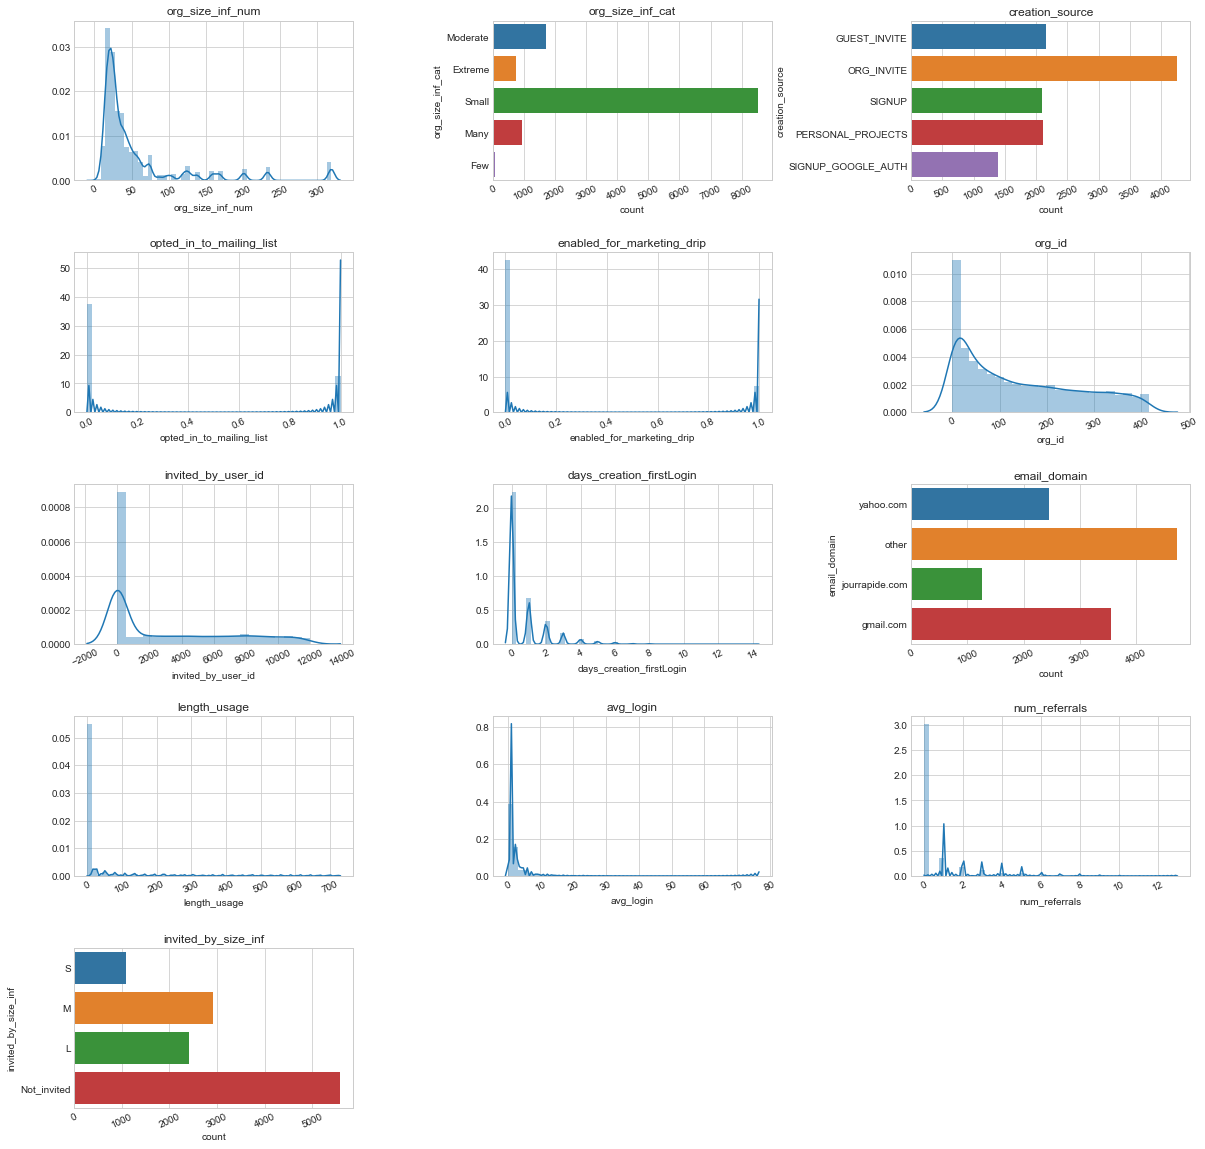

In [38]:
# Let’s plot the distribution of each feature

columns_plots = ['org_size_inf_num', 'org_size_inf_cat', 'creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
               'days_creation_firstLogin', 'email_domain', 'length_usage', 'avg_login', 'num_referrals', 'invited_by_size_inf']

def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object: #Categorical
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else: #Numerical
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
    
plot_distribution(users[columns_plots], cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

### Adopted User: Target for prediction

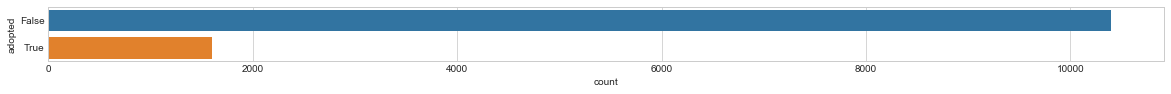

In [39]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,1)) 
sns.countplot(y="adopted", data=users);

## Bi-variate Analysis

So far, we have analyzed all features individually. Let's now start combining some of these features together to obtain further insight into the interactions between them.

In [40]:
columns_continuous = ['adopted', 'org_size_inf_num', 'avg_login', 'num_referrals', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'days_creation_firstLogin']
columns_categorical = ['adopted','org_size_inf_cat', 'creation_source', 'email_domain', 'invited_by_size_inf']

In [41]:
# Plot a count of the categories from each categorical feature split by our prediction class: salary - predclass.
def plot_bivariate_bar(dataset, hue, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    dataset = dataset.select_dtypes(include=[np.object])
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, hue=hue, data=dataset)
            substrings = [s.get_text()[:10] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            
#plot_bivariate_bar(users[columns_categorical], hue='adopted', cols=3, width=20, height=12, hspace=0.4, wspace=0.5)

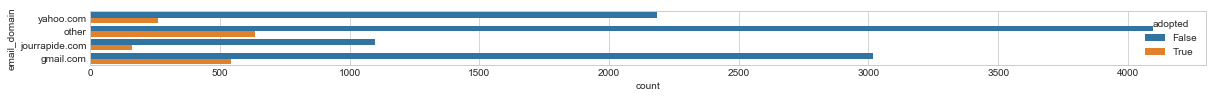

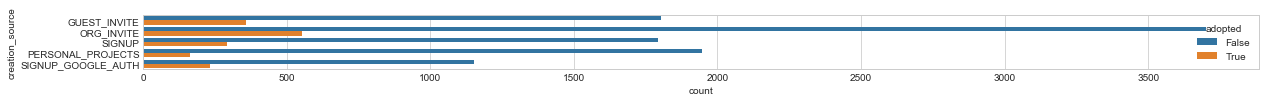

In [42]:
# categorical bi-variate analysis
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,1)) 
sns.countplot(y='email_domain', hue="adopted", data=users);
fig = plt.figure(figsize=(20,1))
sns.countplot(y='creation_source', hue="adopted", data=users);

/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


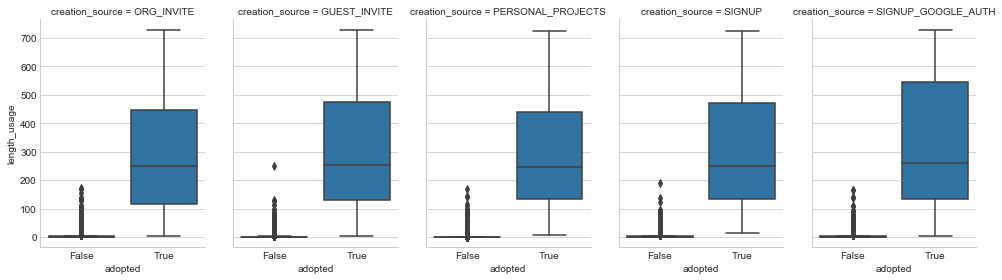

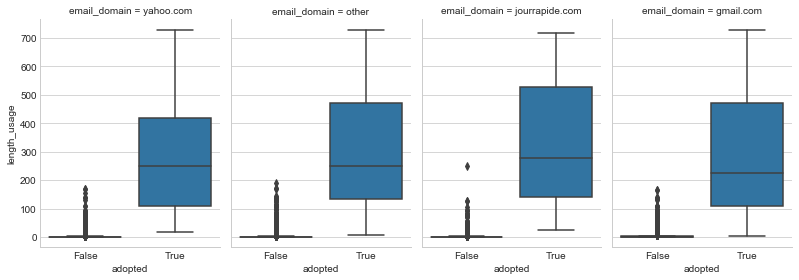

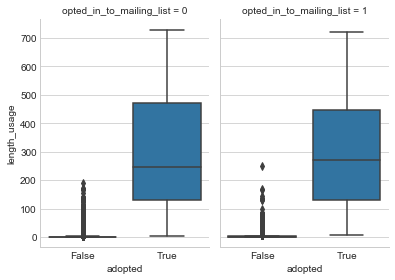

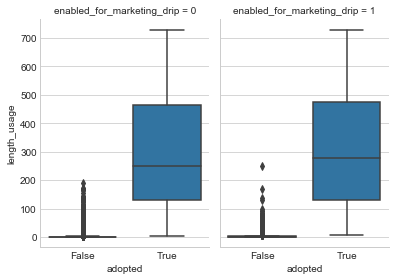

In [43]:
# Effect of Marital Status and Education on Income, across Marital Status.
plt.style.use('seaborn-whitegrid')
ordered_cols = users.creation_source.value_counts().index
g = sns.FacetGrid(users, col='creation_source', col_order=ordered_cols, height=4, aspect=.7)
g = g.map(sns.boxplot, 'adopted', 'length_usage')

g = sns.FacetGrid(users, col='email_domain', height=4, aspect=.7)
g = g.map(sns.boxplot, 'adopted', 'length_usage')

g = sns.FacetGrid(users, col='opted_in_to_mailing_list', height=4, aspect=.7)
g = g.map(sns.boxplot, 'adopted', 'length_usage')

g = sns.FacetGrid(users, col='enabled_for_marketing_drip', height=4, aspect=.7)
g = g.map(sns.boxplot, 'adopted', 'length_usage')

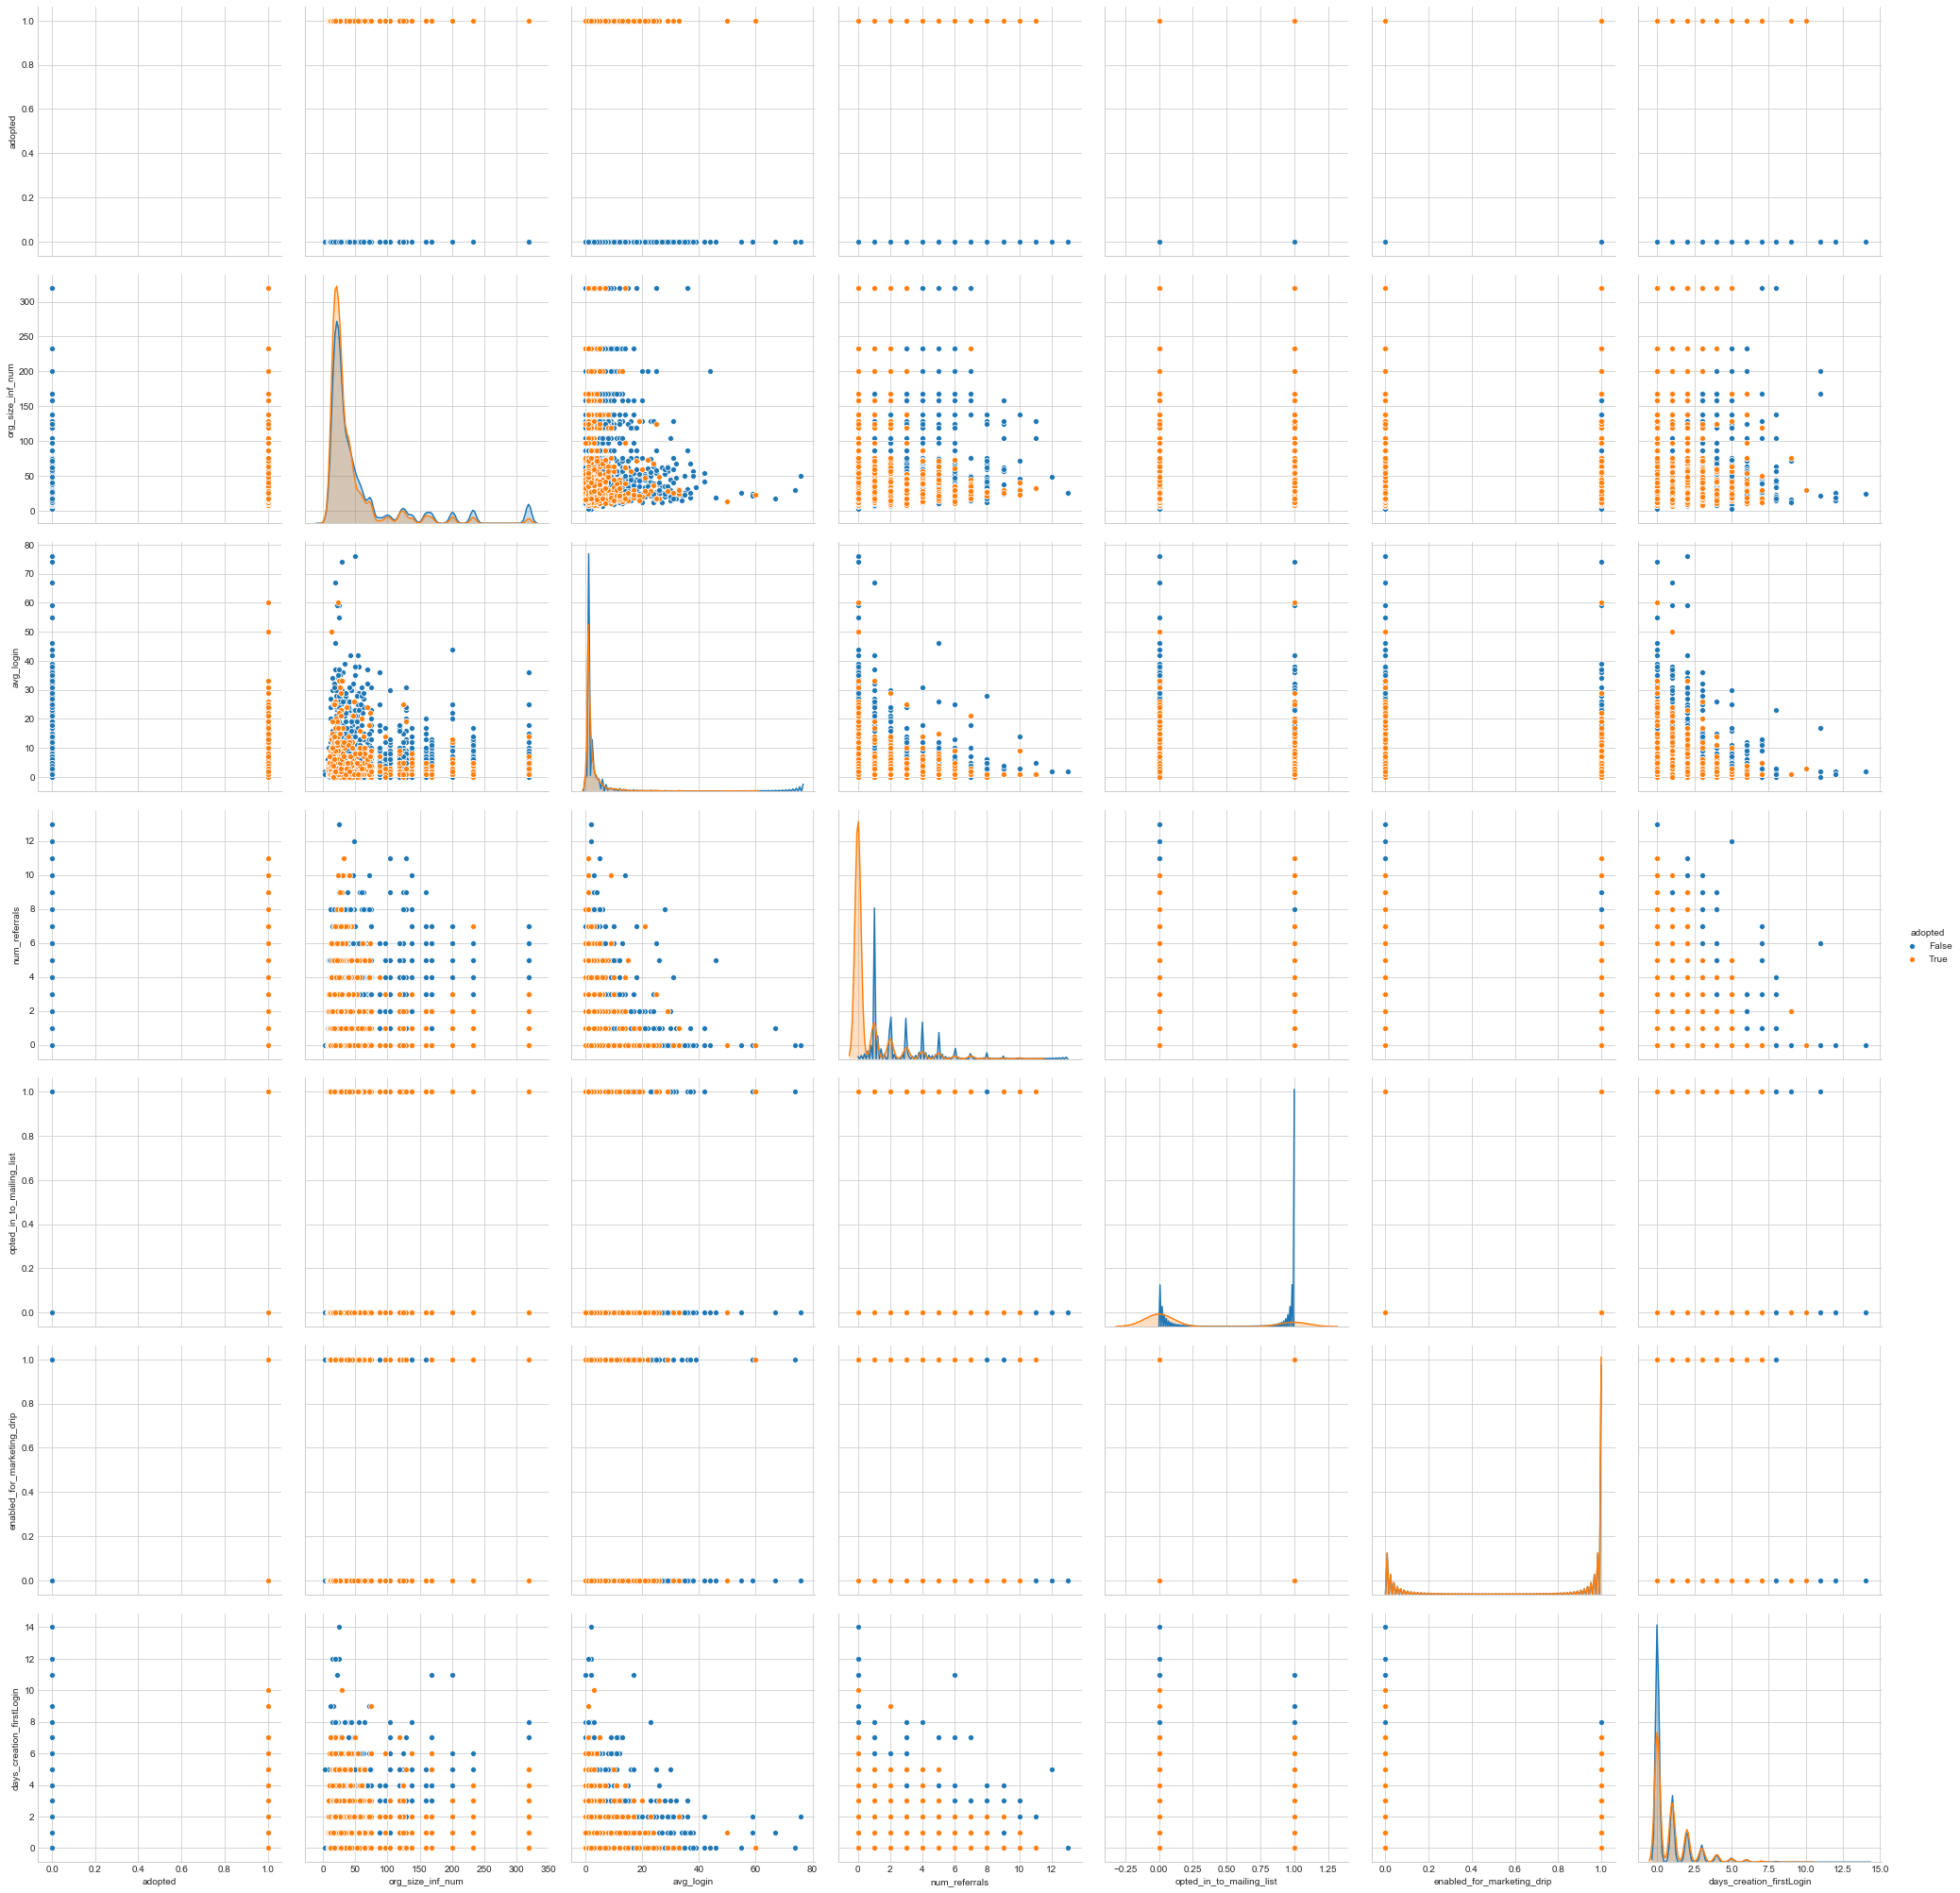

In [44]:
# Interaction between pairs of features.
sns.pairplot(users[columns_continuous], 
             hue="adopted", 
             diag_kind="kde",
             height=4);

# Feature Encoding

In [45]:
from sklearn.preprocessing import LabelEncoder

no_need_cols = ['object_id', 'creation_time', 'name', 'email', 'last_session_creation_time', 
                    'org_id', 'invited_by_user_id', 'firstLogin_time', 'adopted']
                
y = users.adopted
X = users.drop(no_need_cols, axis=1)

The labelEncoder and OneHotEncoder only works on categorical features. 
https://towardsdatascience.com/encoding-categorical-features-21a2651a065c

If the categorical feature is multi class, LabelEncoder will return different values for different classes. In this case, using LabelEncoder only is not a good choice, since it brings in a natural ordering for different classes. 

The first choice method will be pandas get dummies. But if the number of categorical features are huge, DictVectorizer will be a good choice as it supports sparse matrix output.
Let's get both encodings using pandas get dummies and DictVectorizer.

In [46]:
# Categorical boolean mask
categorical_feature_mask = X.dtypes==np.object
# filter categorical columns using mask and turn it into a list
categorical_cols = X.columns[categorical_feature_mask].tolist()
# categorical_cols = ['creation_source', 'email_domain', 'invited_by_size_inf', 'org_size_inf_cat']

## Encoding categorical features 

In [47]:
# Pandas get_dummies 
X_encoded_getdummies = pd.get_dummies(X, columns = categorical_cols, prefix_sep='_', drop_first=True) 
#The drop_first=True drops one column from the resulted dummy features. The purpose is to avoid multicollinearity. 

In [48]:
# DictVectorizer
from sklearn.feature_extraction import DictVectorizer

# turn X into dict
X_dict = X.to_dict(orient='records') # turn each row as key-value pairs

# instantiate a Dictvectorizer object for X
dv_X = DictVectorizer(sparse=False) 
# sparse = False makes the output is not a sparse matrix
# apply dv_X on X_dict
X_encoded_dv = dv_X.fit_transform(X_dict)
print(X_encoded_dv)

# vocabulary
vocab = dv_X.vocabulary_
print(vocab)

[[  0.   1.   0. ...   1.   0.  75.]
 [  0.   0.   1. ...   0.   0. 233.]
 [ 14.   0.   1. ...   0.   1.  32.]
 ...
 [  3.   1.   0. ...   0.   1.  27.]
 [  1.   0.   0. ...   0.   0. 138.]
 [ 12.   0.   0. ...   0.   0. 319.]]
{'creation_source=GUEST_INVITE': 1, 'opted_in_to_mailing_list': 18, 'enabled_for_marketing_drip': 11, 'days_creation_firstLogin': 6, 'email_domain=yahoo.com': 10, 'length_usage': 16, 'avg_login': 0, 'num_referrals': 17, 'invited_by_size_inf=S': 15, 'org_size_inf_num': 24, 'org_size_inf_cat=Moderate': 22, 'creation_source=ORG_INVITE': 2, 'email_domain=other': 9, 'invited_by_size_inf=M': 13, 'org_size_inf_cat=Extreme': 19, 'invited_by_size_inf=L': 12, 'org_size_inf_cat=Small': 23, 'creation_source=SIGNUP': 4, 'email_domain=jourrapide.com': 8, 'invited_by_size_inf=Not_invited': 14, 'creation_source=PERSONAL_PROJECTS': 3, 'email_domain=gmail.com': 7, 'org_size_inf_cat=Many': 21, 'creation_source=SIGNUP_GOOGLE_AUTH': 5, 'org_size_inf_cat=Few': 20}


In [49]:
# last check for missing values
print("Number of y: {}".format(len(y)))
users.info()

Number of y: 12000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 20 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
adopted                       12000 non-null bool
firstLogin_time               12000 non-null datetime64[ns]
days_creation_firstLogin      12000 non-null float64
email_domain                  12000 non-null object
length_usage                  12000 non-null int64
avg_login                     12000 non-null float64
num_referrals       

We decide to use pandas get dummies encoding below.

In [50]:
X = X_encoded_getdummies

# Feature Selction

## Feature Correlation

Correlation is a measure of how much two random variables change together. Features should be uncorrelated with each other and highly correlated to the feature we are trying to predict.

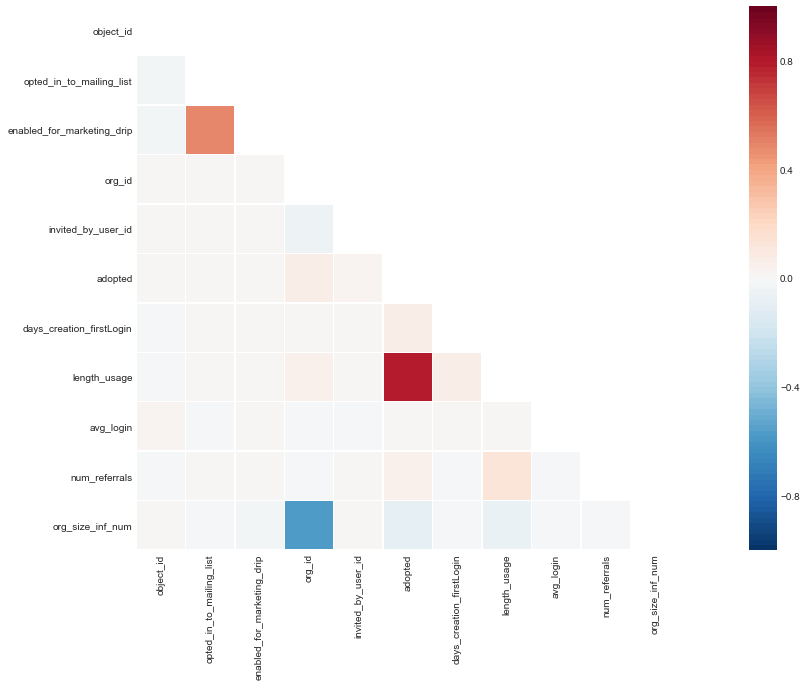

In [51]:
#Create a correlation plot of both datasets.
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(25,10)) 

#plt.subplot(1, 2, 1)
# Generate a mask for the upper triangle
mask = np.zeros_like(users.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(users.corr(), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask, 
            linewidths=.5);

# plt.subplot(1, 2, 2)

## Feature Importance

We use inbuilt class `feature_importances` of tree based classifiers.

Random forest consists of a number of decision trees. Every node in the decision trees is a condition on a single feature, designed to split the data into two so that similar response values end up in the same set.
The measure based on which the optimal condition is chosen is called impurity.
When training a tree, it can be computed how much each feature decreases the weighted impurity in a tree.
For a forest, the impurity measure exposed in sklean's Random Forest implementations.

Feature ranking:
1. feature 3 (0.83)
2. feature 6 (0.05)
3. feature 4 (0.03)
4. feature 2 (0.02)
5. feature 5 (0.01)
6. feature 0 (0.01)
7. feature 12 (0.01)
8. feature 7 (0.01)
9. feature 13 (0.01)
10. feature 20 (0.00)
11. feature 14 (0.00)
12. feature 8 (0.00)
13. feature 1 (0.00)
14. feature 11 (0.00)
15. feature 16 (0.00)
16. feature 15 (0.00)
17. feature 9 (0.00)
18. feature 10 (0.00)
19. feature 19 (0.00)
20. feature 18 (0.00)
21. feature 17 (0.00)


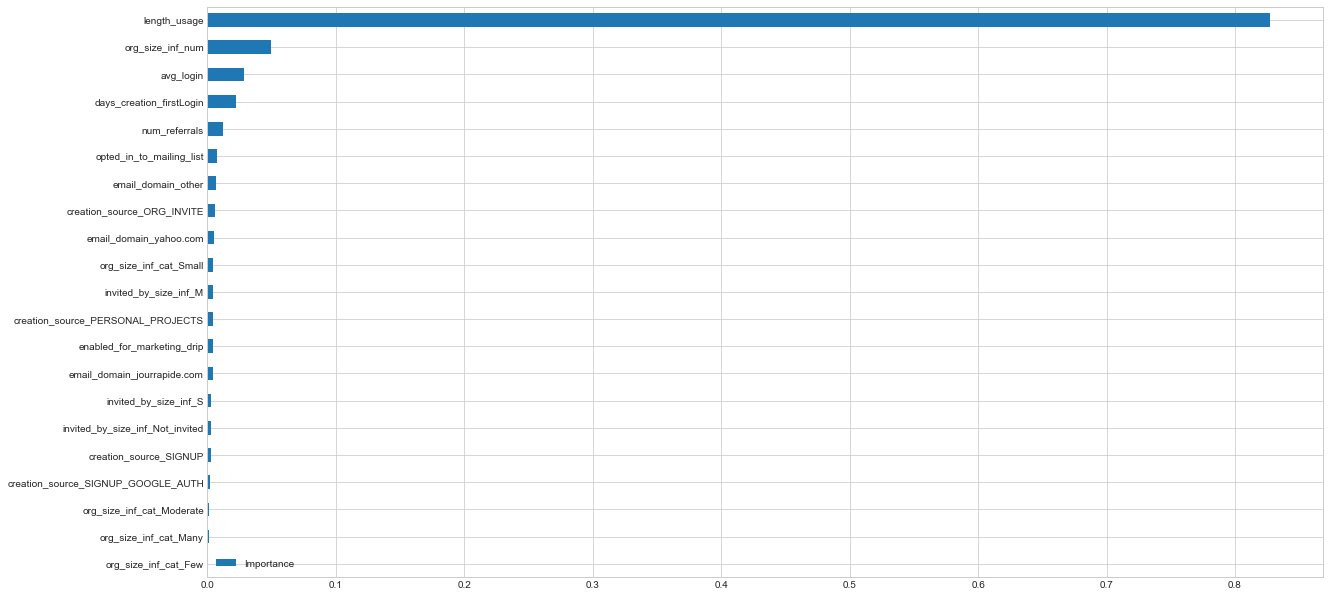

In [52]:
from sklearn.ensemble import RandomForestClassifier

# Using Random Forest to gain an insight on Feature Importance
rfclf = RandomForestClassifier()
rfclf.fit(X, y)

plt.style.use('seaborn-whitegrid')
importances = rfclf.feature_importances_

#####
std = np.std([tree.feature_importances_ for tree in rfclf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%.2f)" % (f + 1, indices[f], importances[indices[f]]))

#####
df_importances = pd.DataFrame(importances, index=X.columns, columns=["Importance"])
df_importances.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importances)/2));

We also used the ExtraTreesClassifier to obtain feature importance. 
**The results of the order of important features is same in both tree based classifiers.**
The coefficients are different.

Feature ranking:
1. feature 3 (0.81)
2. feature 6 (0.05)
3. feature 4 (0.04)
4. feature 2 (0.03)
5. feature 5 (0.02)
6. feature 0 (0.01)
7. feature 12 (0.01)
8. feature 7 (0.01)
9. feature 13 (0.00)
10. feature 20 (0.00)
11. feature 14 (0.01)
12. feature 8 (0.00)
13. feature 1 (0.01)
14. feature 11 (0.00)
15. feature 16 (0.00)
16. feature 15 (0.00)
17. feature 9 (0.00)
18. feature 10 (0.00)
19. feature 19 (0.00)
20. feature 18 (0.00)
21. feature 17 (0.00)


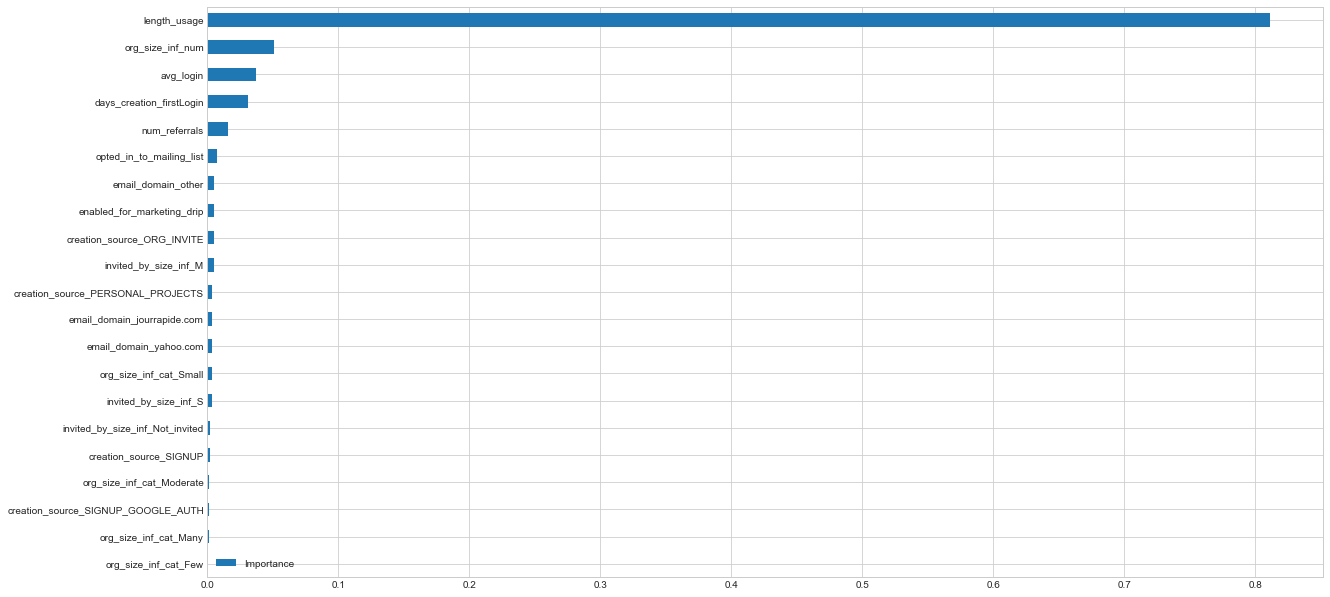

In [53]:
from sklearn.ensemble import ExtraTreesClassifier

etclf = ExtraTreesClassifier(n_estimators=100)
etclf.fit(X,y)

importance_etclf = etclf.feature_importances_
#####
std = np.std([tree.feature_importances_ for tree in rfclf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%.2f)" % (f + 1, indices[f], importance_etclf[indices[f]]))

#####

#plot graph of feature importances for better visualization
df_importance_etclf = pd.DataFrame(importance_etclf, index=X.columns, columns=["Importance"])
df_importance_etclf.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance_etclf)/2));

# feat_importances = pd.Series(etclf.feature_importances_, index=X.columns)
# feat_importances.nlargest(20).sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance_etclf)/2))
# plt.show()

# Modeling

In [54]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

# set random_state SEED variable
SEED = 42

Let's take one last peek at our data before we start running Machine Learning algorithms.

In [55]:
# split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = SEED)

# training set breakdown
#train_success = y_train.sum()
train_total = len(y_train)
#train_percent = train_success / train_total
print('Training Set\nTotal:\t\t{}'.format(train_total))

# test set breakdown
#test_success = y_test.sum()
test_total = len(y_test)
#test_percent = test_success / test_total
print('Test Set\nTotal:\t\t{}'.format(test_total))

Training Set
Total:		8400
Test Set
Total:		3600


## Algorithms

There are various algorithms for classification.

- KNN
- Logistic Regression
- Random Forest
- Naive Bayes
- Stochastic Gradient Decent
- Linear SVC
- Decision Tree
- Gradient Boosted Trees

In [56]:
# Machine learning 
#import sklearn.ensemble as ske
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
#tree
import graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Grid and Random Search
import scipy.stats as st
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

import time
import datetime

In [57]:
# calculate the fpr and tpr for all thresholds of the classification
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

* `cross_val_predict` vs. `cross_val_score`
I think that `cross_val_predict` will be overfit because as the folds increase, more data will be for train and less will for test. So the resultant label is more dependent on training data. Also as already told above, the prediction for one sample is done only once, so it may be susceptible to the splitting of data more. Thats why most of the places or tutorials recommend using the `cross_val_score` for analysis.

In [58]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, X_test, y_test, cv):
    # One Pass
    model = algo.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    if (isinstance(algo, (LogisticRegression, 
                          KNeighborsClassifier, 
                          GaussianNB, 
                          DecisionTreeClassifier, 
                          RandomForestClassifier,
                          GradientBoostingClassifier))):
        probs = model.predict_proba(X_test)[:,1]
    else:
        probs = "Not Available"
    acc = round(model.score(X_test, y_test) * 100, 2) 
    # CV 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, test_pred, acc, acc_cv, probs

### Logistic Regression

In [59]:
# Logistic Regression - Random Search for Hyperparameters

# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# Specify parameters and distributions to sample from
param_dist = {'penalty': ['l2', 'l1'], 
                         'class_weight': [None, 'balanced'],
                         'C': np.logspace(-20, 20, 10000), 
                         'intercept_scaling': np.logspace(-20, 20, 10000)}

# Run Randomized Search
n_iter_search = 10
lrc = LogisticRegression()
random_search = RandomizedSearchCV(lrc, 
                                   n_jobs=-1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 3.49 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.973 (std: 0.002)
Parameters: {'penalty': 'l2', 'intercept_scaling': 7.0710669379733406e-06, 'class_weight': None, 'C': 6.1330819517613944e+16}

Model with rank: 2
Mean validation score: 0.972 (std: 0.001)
Parameters: {'penalty': 'l1', 'intercept_scaling': 4.131060983498117e-20, 'class_weight': None, 'C': 2.7519717056582036e+16}

Model with rank: 3
Mean validation score: 0.968 (std: 0.001)
Parameters: {'penalty': 'l2', 'intercept_scaling': 46.36247548137305, 'class_weight': None, 'C': 4.133915890756998e-17}

Model with rank: 4
Mean validation score: 0.965 (std: 0.003)
Parameters: {'penalty': 'l2', 'intercept_scaling': 28271258037750.188, 'class_weight': 'balanced', 'C': 88.3475721817715}

Model with rank: 5
Mean validation score: 0.958 (std: 0.001)
Parameters: {'penalty': 'l2', 'intercept_scaling': 997470108.6707405, 'class_weight': 'balanced', 'C': 2.863160438340336e-1

In [60]:
# Logistic Regression
start_time = time.time()
train_pred_log, test_pred_log, acc_log, acc_cv_log, probs_log = fit_ml_algo(LogisticRegression(n_jobs = -1), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, y_test,
                                                                 10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Accuracy: 97.81
Accuracy CV 10-Fold: 97.23
Running Time: 0:00:00.327848


In [61]:
print(metrics.classification_report(y_train, train_pred_log))

              precision    recall  f1-score   support

       False       0.98      0.99      0.98      7284
        True       0.93      0.85      0.89      1116

   micro avg       0.97      0.97      0.97      8400
   macro avg       0.95      0.92      0.94      8400
weighted avg       0.97      0.97      0.97      8400



In [62]:
print(metrics.classification_report(y_test, test_pred_log))

              precision    recall  f1-score   support

       False       0.98      0.99      0.99      3114
        True       0.95      0.88      0.92       486

   micro avg       0.98      0.98      0.98      3600
   macro avg       0.97      0.94      0.95      3600
weighted avg       0.98      0.98      0.98      3600



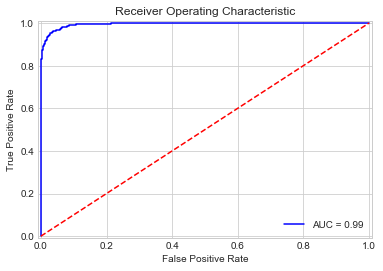

In [63]:
plot_roc_curve(y_test, probs_log)

### k-Nearest Neighbors

In [64]:
# k-Nearest Neighbors
start_time = time.time()
train_pred_knn, test_pred_knn, acc_knn, acc_cv_knn, probs_knn = fit_ml_algo(KNeighborsClassifier(n_neighbors = 3,
                                                                                                 n_jobs = -1), 
                                                                                                 X_train, 
                                                                                                 y_train, 
                                                                                                 X_test, y_test,
                                                                                                 10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 97.06
Accuracy CV 10-Fold: 96.68
Running Time: 0:00:00.924902


In [65]:
print(metrics.classification_report(y_train, train_pred_knn))

              precision    recall  f1-score   support

       False       0.98      0.98      0.98      7284
        True       0.89      0.86      0.87      1116

   micro avg       0.97      0.97      0.97      8400
   macro avg       0.93      0.92      0.93      8400
weighted avg       0.97      0.97      0.97      8400



In [66]:
print(metrics.classification_report(y_test, test_pred_knn))

              precision    recall  f1-score   support

       False       0.98      0.99      0.98      3114
        True       0.91      0.87      0.89       486

   micro avg       0.97      0.97      0.97      3600
   macro avg       0.94      0.93      0.94      3600
weighted avg       0.97      0.97      0.97      3600



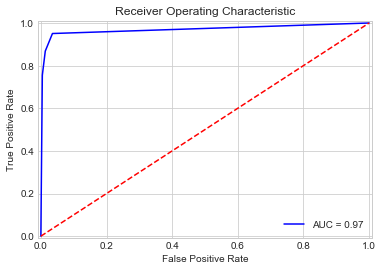

In [67]:
plot_roc_curve(y_test, probs_knn)

### Gaussian Naive Bayes

In [68]:
#Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, test_pred_gaussian, acc_gaussian, acc_cv_gaussian, probs_gau = fit_ml_algo(GaussianNB(), 
                                                                                     X_train, 
                                                                                     y_train, 
                                                                                     X_test, y_test,
                                                                                     10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 96.31
Accuracy CV 10-Fold: 96.07
Running Time: 0:00:00.113510


In [69]:
print(metrics.classification_report(y_train, train_pred_gaussian))

              precision    recall  f1-score   support

       False       0.99      0.97      0.98      7284
        True       0.81      0.92      0.86      1116

   micro avg       0.96      0.96      0.96      8400
   macro avg       0.90      0.94      0.92      8400
weighted avg       0.96      0.96      0.96      8400



In [70]:
print(metrics.classification_report(y_test, test_pred_gaussian))

              precision    recall  f1-score   support

       False       0.99      0.97      0.98      3114
        True       0.82      0.94      0.87       486

   micro avg       0.96      0.96      0.96      3600
   macro avg       0.90      0.95      0.93      3600
weighted avg       0.97      0.96      0.96      3600



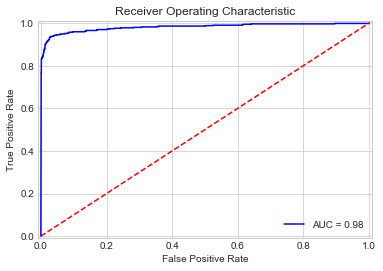

In [71]:
plot_roc_curve(y_test, probs_gau)

### Linear SVC

In [72]:
# Linear SVC
start_time = time.time()
train_pred_svc, test_pred_svc, acc_linear_svc, acc_cv_linear_svc, _ = fit_ml_algo(LinearSVC(),
                                                                                           X_train, 
                                                                                           y_train,
                                                                                           X_test, y_test,
                                                                                           10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 97.81
Accuracy CV 10-Fold: 94.49
Running Time: 0:00:02.276546


In [73]:
print(metrics.classification_report(y_train, train_pred_svc))

              precision    recall  f1-score   support

       False       0.96      0.97      0.97      7284
        True       0.81      0.76      0.79      1116

   micro avg       0.94      0.94      0.94      8400
   macro avg       0.89      0.87      0.88      8400
weighted avg       0.94      0.94      0.94      8400



In [74]:
print(metrics.classification_report(y_test, test_pred_svc))

              precision    recall  f1-score   support

       False       0.98      0.99      0.99      3114
        True       0.94      0.90      0.92       486

   micro avg       0.98      0.98      0.98      3600
   macro avg       0.96      0.94      0.95      3600
weighted avg       0.98      0.98      0.98      3600



### Stochastic Gradient Descent

In [75]:
#Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, test_pred_sgd, acc_sgd, acc_cv_sgd, _ = fit_ml_algo(SGDClassifier(n_jobs = -1), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, y_test,
                                                                 10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 97.31
Accuracy CV 10-Fold: 96.4
Running Time: 0:00:00.208167


In [76]:
print(metrics.classification_report(y_train, train_pred_sgd))

              precision    recall  f1-score   support

       False       0.98      0.98      0.98      7284
        True       0.87      0.86      0.86      1116

   micro avg       0.96      0.96      0.96      8400
   macro avg       0.92      0.92      0.92      8400
weighted avg       0.96      0.96      0.96      8400



In [77]:
print(metrics.classification_report(y_test, test_pred_sgd))

              precision    recall  f1-score   support

       False       0.99      0.98      0.98      3114
        True       0.88      0.93      0.90       486

   micro avg       0.97      0.97      0.97      3600
   macro avg       0.93      0.95      0.94      3600
weighted avg       0.97      0.97      0.97      3600



### Decision Tree Classifier

In [78]:
# Decision Tree Classifier
start_time = time.time()

def fit_ml_algo_clf(algo, X_train, y_train, X_test, y_test, cv):
    # One Pass
    model = algo.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    if (isinstance(algo, (LogisticRegression, 
                          KNeighborsClassifier, 
                          GaussianNB, 
                          DecisionTreeClassifier, 
                          RandomForestClassifier,
                          GradientBoostingClassifier))):
        probs = model.predict_proba(X_test)[:,1]
    else:
        probs = "Not Available"
    acc = round(model.score(X_test, y_test) * 100, 2) 
    # CV 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, test_pred, acc, acc_cv, probs, model

train_pred_dt, test_pred_dt, acc_dt, acc_cv_dt, probs_dt, clf_obj = fit_ml_algo_clf(DecisionTreeClassifier(), 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, y_test,
                                                             10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 96.17
Accuracy CV 10-Fold: 95.73
Running Time: 0:00:00.132704


In [79]:
print(metrics.classification_report(y_train, train_pred_dt))

              precision    recall  f1-score   support

       False       0.98      0.97      0.98      7284
        True       0.83      0.86      0.84      1116

   micro avg       0.96      0.96      0.96      8400
   macro avg       0.90      0.91      0.91      8400
weighted avg       0.96      0.96      0.96      8400



In [80]:
print(metrics.classification_report(y_test, test_pred_dt))

              precision    recall  f1-score   support

       False       0.98      0.98      0.98      3114
        True       0.86      0.86      0.86       486

   micro avg       0.96      0.96      0.96      3600
   macro avg       0.92      0.92      0.92      3600
weighted avg       0.96      0.96      0.96      3600



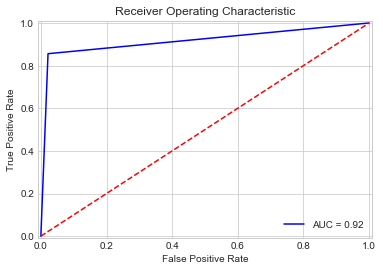

In [81]:
plot_roc_curve(y_test, probs_dt)

In [82]:
# Visualization
features = list(X_train.columns)
targets = ['No adopted', 'Adopted']
dot_data = tree.export_graphviz(clf_obj, out_file=None, feature_names=features, class_names=targets, 
                                filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)
#graph

### Random Forest Classifier

In [83]:
# Random Forest Classifier - Random Search for Hyperparameters

# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# Specify parameters and distributions to sample from
param_dist = {"max_depth": [10, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 20),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# Run Randomized Search
n_iter_search = 10
rfc = RandomForestClassifier(n_estimators=10)
random_search = RandomizedSearchCV(rfc, 
                                   n_jobs = -1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)


RandomizedSearchCV took 0.47 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.973 (std: 0.001)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 12}

Model with rank: 2
Mean validation score: 0.971 (std: 0.001)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'min_samples_leaf': 3, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 0.971 (std: 0.001)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 8, 'min_samples_leaf': 6, 'min_samples_split': 17}

Model with rank: 4
Mean validation score: 0.971 (std: 0.002)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 4, 'min_samples_leaf': 2, 'min_samples_split': 3}

Model with rank: 5
Mean validation score: 0.971 (std: 0.002)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'm

In [84]:
# Random Forest Classifier
start_time = time.time()
rfc = RandomForestClassifier(n_estimators=10, 
                             min_samples_leaf=2,
                             min_samples_split=17, 
                             criterion='gini', 
                             max_features=8)
train_pred_rf, test_pred_rf, acc_rf, acc_cv_rf, probs_rf = fit_ml_algo(rfc, 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, y_test,
                                                             10)
rf_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print("Running Time: %s" % datetime.timedelta(seconds=rf_time))

Accuracy: 97.64
Accuracy CV 10-Fold: 97.18
Running Time: 0:00:00.249185


In [85]:
print(metrics.classification_report(y_train, train_pred_rf))

              precision    recall  f1-score   support

       False       0.98      0.99      0.98      7284
        True       0.91      0.87      0.89      1116

   micro avg       0.97      0.97      0.97      8400
   macro avg       0.95      0.93      0.94      8400
weighted avg       0.97      0.97      0.97      8400



In [86]:
print(metrics.classification_report(y_test, test_pred_rf))

              precision    recall  f1-score   support

       False       0.98      0.99      0.99      3114
        True       0.94      0.88      0.91       486

   micro avg       0.98      0.98      0.98      3600
   macro avg       0.96      0.94      0.95      3600
weighted avg       0.98      0.98      0.98      3600



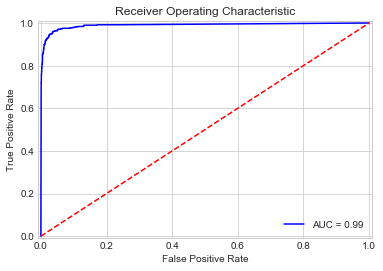

In [87]:
plot_roc_curve(y_test, probs_rf)

### Gradient Boosting Trees

In [88]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, test_pred_gbt, acc_gbt, acc_cv_gbt, probs_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, y_test,                                                                            
                                                                 10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 97.78
Accuracy CV 10-Fold: 97.18
Running Time: 0:00:01.852532


In [89]:
print(metrics.classification_report(y_train, train_pred_gbt))

              precision    recall  f1-score   support

       False       0.98      0.99      0.98      7284
        True       0.91      0.87      0.89      1116

   micro avg       0.97      0.97      0.97      8400
   macro avg       0.95      0.93      0.94      8400
weighted avg       0.97      0.97      0.97      8400



In [90]:
print(metrics.classification_report(y_test, test_pred_gbt))

              precision    recall  f1-score   support

       False       0.98      0.99      0.99      3114
        True       0.94      0.89      0.92       486

   micro avg       0.98      0.98      0.98      3600
   macro avg       0.96      0.94      0.95      3600
weighted avg       0.98      0.98      0.98      3600



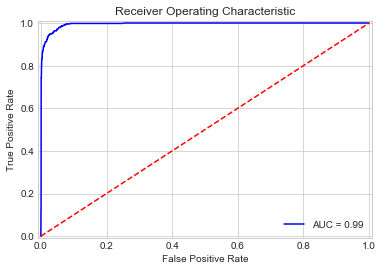

In [91]:
plot_roc_curve(y_test, probs_gbt)

## Results

### Train and test split 

In [92]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees'],
    'Accuracy': [
        acc_knn, 
        acc_log, 
        acc_rf, 
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt
    ]})
models.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
1,Logistic Regression,97.81
5,Linear SVC,97.81
7,Gradient Boosting Trees,97.78
2,Random Forest,97.64
4,Stochastic Gradient Decent,97.31
0,KNN,97.06
3,Naive Bayes,96.31
6,Decision Tree,96.17


### 10-Fold CV

In [93]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees'],
    'Accuracy (10-fold CV)': [
        acc_cv_knn, 
        acc_cv_log,     
        acc_cv_rf, 
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt
    ]})
models.sort_values(by='Accuracy (10-fold CV)', ascending=False)

,Model,Accuracy (10-fold CV)
1,Logistic Regression,97.23
2,Random Forest,97.18
7,Gradient Boosting Trees,97.18
0,KNN,96.68
4,Stochastic Gradient Decent,96.40
3,Naive Bayes,96.07
6,Decision Tree,95.73
5,Linear SVC,94.49


# Conclusion


We have performed two methods of the [feature selection](#Feature-Selction).

In the [feature correlation](#Feature-Correalation), we have drawn the heat map and found that **there are strong correlation between `adopted` users and `length_usage`.**
The length usage denotes the days from the first account creation to the last login time. 
This feature represents how a user consistenly have has been used the services.

In the [feature impotance analysis](#Feature-Importance), we use inbuilt class `feature_importances` of tree based classifiers (e.g., *RandomForestClassifier* and *ExtraTreesClassifier*).
The results of the order of important features is same in both tree based classifiers even thought the coefficients are different.
Likewise the results in the feature correlation, we see that the **`length_usage` is the strongest indicator for explaining the `adopted` users.** The feature importances are 0.83 (*RandomForestClassifier*) and 0.81 (*ExtraTreesClassifier*). 
The feature importance of the `adopted` feature was shown to be a big difference compared to other variables.

Next, we could observe that the features had the importance in the following order: 
`org_size_inf_num`, `avg_login`, `days_creation_firstLogin`, `num_refererals`, and `opted_in_to_mailing_list`.
Those indicate that the frequency of organizations, the average time of login intervals, the days between initial login and first creation, the number of user's referrals, and the subcription in the mailing list.
**All the highly impacting factors are related to customer's engagement to services or products.**
The more detailed explanation of features is given [here](#Derived-Features).

For the [model results](#Results),
we obtain the best accuracy in the Logistic Regression model (Accuracy in 10-fold CV: 97.23).

# Reference 
Basic Time Series Manipulation with Pandas: https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea

In [94]:
# combined AUC graphs

# plt.style.use('seaborn-whitegrid')
# fig = plt.figure(figsize=(10,10)) 

# models = [
#     'KNN', 
#     'Logistic Regression', 
#     'Random Forest', 
#     'Naive Bayes', 
#     'Decision Tree', 
#     'Gradient Boosting Trees'
# ]
# probs = [
#     probs_knn,
#     probs_log,
#     probs_rf,
#     probs_gau,
#     probs_dt,
#     probs_gbt
# ]
# colors = [
#     'blue',
#     'green',
#     'red',
#     'cyan',
#     'magenta',
#     'yellow',
# ]
    
# plt.title('Receiver Operating Characteristic')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([-0.01, 1.01])
# plt.ylim([-0.01, 1.01])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')

# def plot_roc_curves(y_test, prob, model):
#     fpr, tpr, threshold = metrics.roc_curve(y_test, prob)
#     roc_auc = metrics.auc(fpr, tpr)
#     plt.plot(fpr, tpr, 'b', label = model + ' AUC = %0.2f' % roc_auc, color=colors[i])
#     plt.legend(loc = 'lower right')
    
# for i, model in list(enumerate(models)):
#     plot_roc_curves(y_test, probs[i], models[i])
    
# plt.show()